# RAG with Azure Document Intelligence and Azure OpenAI gpt-4o mini (document analysis)

## Architecture
<img src="https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/media/rag/azure-rag-processing.png" width=800>


## Note
Document Intelligence public preview releases provide early access to features that are in active development. Features, approaches, and processes may change, prior to General Availability (GA), based on user feedback.<br>

The public preview version of Document Intelligence client libraries default to REST API version 2024-07-31-preview.
Public preview version 2024-07-31-preview is currently only available in the following Azure regions. Note that the custom generative (document field extraction) model in AI Studio is only available in North Central US region:
- East US
- West US2
- West Europe
- North Central US

## Documentation

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-layout?view=doc-intel-4.0.0&tabs=sample-code


In [1]:
import gradio as gr
import json
import langchain
import matplotlib.pyplot as plt
import openai
import os
import pytz
import requests
import sys
import time

from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from dotenv import load_dotenv
from datetime import datetime
from langchain import hub
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnableMap
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores.azuresearch import AzureSearch
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from operator import itemgetter

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")
print(f"Langchain version: {langchain.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.43.0
Langchain version: 0.2.11


In [3]:
# Local timezone datetime
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
now = datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S")
print(f"Local time in {local_tz}: {now}")

Local time in Europe/Amsterdam: 06-Sep-2024 10:46:25


## 1. Settings

In [4]:
load_dotenv("azure.env")

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# Azure OpenAI   
AOAI_API_ENDPOINT: str  = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AOAI_API_KEY: str  = os.getenv("AZURE_OPENAI_API_KEY")

# Azure AI Search
AZURE_AISEARCH_ENDPOINT: str = os.getenv("AZURE_SEARCH_ENDPOINT")
AZURE_AISEARCH_KEY: str = os.getenv("AZURE_SEARCH_KEY")

In [5]:
# Azure OpenAI embeddings model
AOAI_EMBEDDINGS_MODEL: str = "text-embedding-ada-002"

# GPT model
AOAI_DEPLOYMENT_NAME: str = "gpt-4o-mini"
# API Version
AOAI_API_VERSION: str = "2024-07-01-preview"
# Type
AOAI_API_TYPE: str = "azure"

In [6]:
# Azure AI Search Index to create
azure_aisearch_index_name: str = "index_" + datetime.now(local_tz).strftime("%d%b%Y_%H%M%S").lower()

## 2. File to analyse with Azure Document Intelligence

In [7]:
DOCS_DIR = "documents"

os.makedirs(DOCS_DIR, exist_ok=True)

In [8]:
document_file = os.path.join(DOCS_DIR, "phi3.pdf")

!wget https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/phi3.pdf -O $document_file

--2024-09-06 08:46:25--  https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/phi3.pdf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/phi3.pdf [following]
--2024-09-06 08:46:25--  https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/phi3.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3854167 (3.7M) [application/octet-stream]
Saving to: ‘documents/phi3.pdf’

documents/phi3.pdf  100%[===================>]   3.67M  --.-KB/s    in 0.01s   

2024-09-06 08:46:25 (247 MB/s) - ‘documents/phi3.pdf’ saved [3854167/385

In [9]:
!ls $document_file -lh

-rwxrwxrwx 1 root root 3.7M Sep  6 08:46 documents/phi3.pdf


### Azure Document Intelligence layout example

<img src="https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/media/rag/markdown-text-output.png?view=doc-intel-4.0.0">


- **Simplified processing.** You can parse different document types, such as digital and scanned PDFs, images, office files (docx, xlsx, pptx), and HTML, with just a single API call.

- **Scalability and AI quality.** The Layout model is highly scalable in Optical Character Recognition (OCR), table extraction, and document structure analysis. It supports 309 printed and 12 handwritten languages, further ensuring high-quality results driven by AI capabilities.

- **Large language model (LLM) compatibility.** The Layout model Markdown formatted output is LLM friendly and facilitates seamless integration into your workflows. You can turn any table in a document into Markdown format and avoid extensive effort parsing the documents for greater LLM understanding.

The task of recognizing small text from large-size documents, like engineering drawings, is a challenge. Often the text is mixed with other graphical elements and has varying fonts, sizes, and orientations. Moreover, the text can be broken into separate parts or connected with other symbols. Document Intelligence now supports extracting content from these types of documents with the **ocr.highResolution** capability.

In [10]:
start = time.time()

loader = AzureAIDocumentIntelligenceLoader(
    file_path=document_file,  # File to process
    api_key=AZURE_DOCUMENT_INTELLIGENCE_KEY, # Key
    api_endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,  # Endpoint
    api_model="prebuilt-layout",  # Prebuilt layout of Azure Doc Intelligence
    analysis_features=["ocrHighResolution"],  # To get OCR High resolution
)

# Loading the document
print("Processing the document with Azure Document Intelligence...")
documents = loader.load()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 14 seconds


In [11]:
documents

[Document(page_content='Phi-3 Technical Report: A Highly Capable Language Model Locally on Your Phone\n===\n\nMicrosoft\n\n\n# Abstract\n\nWe introduce phi-3-mini, a 3.8 billion parameter language model trained on 3.3 trillion tokens, whose overall performance, as measured by both academic benchmarks and internal testing, rivals that of models such as Mixtral 8x7B and GPT-3.5 (e.g., phi-3-mini achieves 69% on MMLU and 8.38 on MT-bench), despite being small enough to be deployed on a phone. The innovation lies entirely in our dataset for training, a scaled-up version of the one used for phi-2, composed of heavily filtered publicly available web data and synthetic data. The model is also further aligned for robustness, safety, and chat format. We also provide some initial parameter-scaling results with a 7B and 14B models trained for 4.8T tokens, called phi-3-small and phi-3-medium, both significantly more capable than phi-3-mini (e.g., respectively 75% and 78% on MMLU, and 8.7 and 8.9 o

### Semantic chunking

**Markdown** is a structured and formatted markup language and a popular input for enabling semantic chunking in RAG (Retrieval-Augmented Generation). You can use the Markdown content from the Layout model to split documents based on paragraph boundaries, create specific chunks for tables, and fine-tune your chunking strategy to improve the quality of the generated responses.

This method divides the text into chunks based on **semantic understanding**. Division boundaries are focused on sentence subject and use significant computational algorithmically complex resources. However, it has the distinct advantage of maintaining semantic consistency within each chunk. It's useful for text summarization, sentiment analysis, and document classification tasks.

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0#semantic-chunking

In [12]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]

text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
docs_string = documents[0].page_content
chunks = text_splitter.split_text(docs_string)

print(f"Length of chunks = {len(chunks)}")

Length of chunks = 17


In [13]:
chunk_size_list = []

for idx, chunk in enumerate(chunks, start=1):
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk.page_content)}\n")
    print(f"\033[1;34m{chunk.page_content}\033[0m\n")
    chunk_size_list.append(len(chunk.page_content))

***** Chunk 1 *****
Length of chunk = 93

Phi-3 Technical Report: A Highly Capable Language Model Locally on Your Phone
===  
Microsoft

***** Chunk 2 *****
Length of chunk = 1028

We introduce phi-3-mini, a 3.8 billion parameter language model trained on 3.3 trillion tokens, whose overall performance, as measured by both academic benchmarks and internal testing, rivals that of models such as Mixtral 8x7B and GPT-3.5 (e.g., phi-3-mini achieves 69% on MMLU and 8.38 on MT-bench), despite being small enough to be deployed on a phone. The innovation lies entirely in our dataset for training, a scaled-up version of the one used for phi-2, composed of heavily filtered publicly available web data and synthetic data. The model is also further aligned for robustness, safety, and chat format. We also provide some initial parameter-scaling results with a 7B and 14B models trained for 4.8T tokens, called phi-3-small and phi-3-medium, both significantly more capable than phi-3-mini (e.g., respectiv

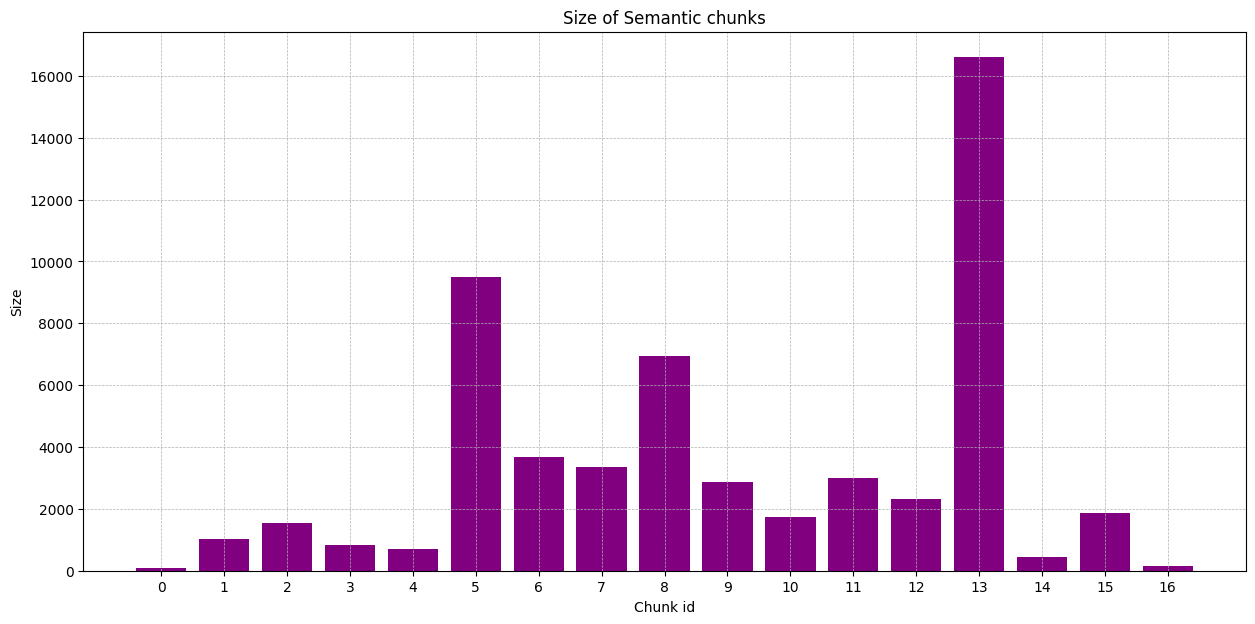

In [14]:
x = range(len(chunk_size_list))
bar_color = 'purple'

plt.figure(figsize=(15, 7))
plt.bar(x, chunk_size_list, color=bar_color)
plt.xlabel('Chunk id')
plt.ylabel('Size')
plt.title('Size of Semantic chunks')
plt.xticks(x)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.show()

## 3. Azure AI Search

In [15]:
azure_openai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment=AOAI_EMBEDDINGS_MODEL,
    openai_api_version=AOAI_API_VERSION,
    azure_endpoint=AOAI_API_ENDPOINT,
    openai_api_type=AOAI_API_TYPE,
)

In [16]:
azure_openai_embeddings

AzureOpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x7fc08d611d80>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7fc08dc41cc0>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='2024-07-01-preview', openai_api_base=None, openai_api_type='azure', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=2048, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True, azure_endpoint='https://azureopenai-eastus-sr.openai.azure.com/', azure_ad_token=None, azure_ad_token_provider=None, validate_base_url=True)

In [17]:
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=AZURE_AISEARCH_ENDPOINT,
    azure_search_key=AZURE_AISEARCH_KEY,
    index_name=azure_aisearch_index_name,
    embedding_function=azure_openai_embeddings.embed_query,
)

In [18]:
start = time.time()

print(f"Adding the documents into Azure AI Search index: {azure_aisearch_index_name}")
vector_store.add_documents(documents=chunks)

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Adding the documents into Azure AI Search index: index_06sep2024_104625

Done
Elapsed time = 0 minutes and 4 seconds


### Index status

In [19]:
headers = {"Content-Type": "application/json", "api-key": AZURE_AISEARCH_KEY}
params = {"api-version": "2024-07-01"}

index_status = requests.get(
    f"{AZURE_AISEARCH_ENDPOINT}/indexes/{azure_aisearch_index_name}", headers=headers, params=params
)

print("\033[1;34m", end="")
print(json.dumps(index_status.json(), indent=5))

{
     "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DCCE506E4AFCFB\"",
     "name": "index_06sep2024_104625",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "stored": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "dimensions": null,
               "vectorSearchProfile": null,
               "vectorEncoding": null,
               "synonymMaps": []
          },
          {
               "name": "content",
               "type": "Edm.String",
               "searchable": true,
               "filterable": false,
               "retrieva

## 4. Azure OpenAI LLM

In [20]:
llm = AzureChatOpenAI(
    openai_api_version=AOAI_API_VERSION,
    azure_deployment=AOAI_DEPLOYMENT_NAME,
    azure_endpoint=AOAI_API_ENDPOINT,
    openai_api_type=AOAI_API_TYPE,
    temperature=0,
)

In [21]:
llm

AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7fc08d7b8c10>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7fc08d7bbbe0>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='', azure_endpoint='https://azureopenai-eastus-sr.openai.azure.com/', deployment_name='gpt-4o-mini', openai_api_version='2024-07-01-preview', openai_api_type='azure')

## 5. Q&A

In [22]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3},
)

In [23]:
# Getting a prompt template
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [24]:
def format_docs(docs):
    """
    Format docs
    """
    return "\n\n".join(doc.page_content for doc in docs)

In [25]:
rag_chain = ({
    "context": retriever | format_docs,
    "question": RunnablePassthrough()
}
             | prompt
             | llm
             | StrOutputParser())

In [26]:
def qna(question):
    """
    QnA function to get a response for a given question.

    This function takes a question as input and uses a response generation system
    to produce an answer. It handles exceptions and displays the response in 
    colored output for better readability.

    Parameters:
    question (str): The question to be answered.
    """
    print("\033[1;34m", end="")

    try:
        response = rag_chain.invoke(question)
        print(response)
        print("\033[1;32m")
        print(f"Powered by Azure AI")
    except Exception as e:
        print("\033[1;31m")
        print(f"[Error] {e}")

In [27]:
question = "What is the language in this document?"

qna(question)

The language in the document is primarily English. It discusses the capabilities and performance of the phi-3 language model and its training data. Additionally, it mentions the model's limitations and future directions for multilingual capabilities.

Powered by Azure AI


In [28]:
question = "What are the companies mentionned in this document?"

qna(question)

The companies mentioned in the document are Microsoft and UC Berkeley. Additionally, various models and baselines are referenced, including Claude 3 Haiku and GPT-4V-Turbo.

Powered by Azure AI


In [29]:
question = "What are the technologies in this document?"
qna(question)

The technologies mentioned in the document include the Phi-3-Vision model, which is a multimodal model combining an image encoder (CLIP ViT-L/14) and a transformer decoder (phi-3-mini-128K-instruct). It utilizes a dynamic cropping strategy for high-resolution images and employs a pre-training phase with diverse datasets, including image-text pairs and synthetic data from OCR. Additionally, the model undergoes supervised finetuning and direct preference optimization for enhanced performance.

Powered by Azure AI


In [30]:
question = "What is phi3?"

qna(question)

Phi-3 refers to a series of language models developed by Microsoft, including phi-3-mini, phi-3-small, and phi-3-medium, with parameters ranging from 3.8 billion to 14 billion. These models are trained on extensive datasets and are designed for various applications, including chat and multimodal tasks. Phi-3-mini, in particular, is notable for its performance and safety alignment, making it suitable for deployment on devices like phones.

Powered by Azure AI


In [31]:
question = "What are the differences between phi3 mini and phi3 small?"

qna(question)

The phi-3-mini model has 3.8 billion parameters and is designed for deployment on mobile devices, while the phi-3-small model has 7 billion parameters and offers improved performance. The phi-3-small model features a larger vocabulary size, a longer default context length, and utilizes advanced attention mechanisms for better efficiency. Overall, phi-3-small is significantly more capable than phi-3-mini in terms of language understanding and reasoning.

Powered by Azure AI


In [32]:
question = "What can you tell about the benchmarks for phi3 mini and phi3 small?"

qna(question)

The phi-3-mini model has 3.8 billion parameters and achieves 68.8% on the MMLU benchmark and 8.38 on MT-bench. In contrast, the phi-3-small model, with 7 billion parameters, performs better, scoring 75.7% on MMLU and 8.70 on MT-bench. Both models utilize a high-quality training dataset, but phi-3-small is designed for enhanced performance and efficiency.

Powered by Azure AI


In [33]:
question = "What is phi3 vision?"

qna(question)

Phi3 Vision is a multimodal model with 4.2 billion parameters that processes images and textual prompts to generate textual outputs. It consists of an image encoder and a transformer decoder, utilizing a dynamic cropping strategy for high-resolution images. The model is pre-trained on a diverse dataset of image-text pairs and undergoes supervised fine-tuning and direct preference optimization for enhanced performance.

Powered by Azure AI


In [34]:
question = "How about the weakness of these models?"

qna(question)

The weaknesses of these models include limited capacity for storing factual knowledge, which can lead to low performance on tasks like TriviaQA. Additionally, they may struggle with multilingual capabilities and are prone to issues such as factual inaccuracies, biases, and inappropriate content generation. While efforts are being made to mitigate these challenges, significant work remains to fully address them.

Powered by Azure AI


In [35]:
question = "How about the comparison results on public and private multi-modal RAI benchmarks?"

qna(question)

The comparison results on public and private multi-modal RAI benchmarks show that Phi-3-Vision outperforms other models, achieving higher scores in both internal and public benchmarks like RTVLM and VLGuard. Specifically, Phi-3-Vision scored 8.30 on the internal benchmark and 4.64 on RTVLM, while its performance on VLGuard was 9.12. The results indicate that safety post-training significantly enhances RAI performance across nearly all categories.

Powered by Azure AI


### With references

In [36]:
question = "What is the number of parameters of the vision model?"

qna(question)

The vision model, Phi-3-Vision, has 4.2 billion parameters. It is designed to process both images and textual prompts. This model combines an image encoder and a transformer decoder for multimodal tasks.

Powered by Azure AI


In [37]:
rag_chain_from_docs = (
    {
        "context": lambda input: format_docs(input["documents"]),
        "question": itemgetter("question"),
    }
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableMap(
    {"documents": retriever, "question": RunnablePassthrough()}
) | {
    "documents": lambda input: [doc.metadata for doc in input["documents"]],
    "answer": rag_chain_from_docs,
}

print("\033[1;34m", end="")
rag_chain_with_source.invoke(question)

{'documents': [{'Header 1': '6 Phi-3-Vision',
   'Header 2': '6.1 Technical Specifications'},
  {'Header 1': '6 Phi-3-Vision', 'Header 2': '6.2 Academic benchmarks'},
  {'Header 1': 'Abstract'},
  {'Header 1': 'Introduction 1'}],
 'answer': 'The vision model, Phi-3-Vision, has 4.2 billion parameters. It is designed to process both images and textual prompts. This model combines an image encoder and a transformer decoder for multimodal tasks.'}

## 6. Webapp

In [38]:
def webapp_function(prompt):
    """
    Webapp function
    """
    return rag_chain.invoke(prompt)

In [39]:
questions_list = [
    "What is the language in this document?",
    "Classify this document into one of these categories: ART, MUSIC, AI, POLITICS",
    "What are the technologies in this document?",
    "What is phi3?",
    "What are the differences between phi3 mini and phi3 small?",
    "What can you tell about the benchmarks for phi3 mini and phi3 small?",
    "How about the comparison results on public and private multi-modal RAI benchmarks?",
]

footnote = "Powered by Azure AI services"
logo = "https://github.com/retkowsky/images/blob/master/adi_logo.jpg?raw=true"
image = "<center> <img src= {} width=150px></center>".format(logo)
title = "RAG with Azure Document Intelligence and Azure OpenAI GPT-4o mini"
theme = "snehilsanyal/scikit-learn"  # Themes: https://huggingface.co/spaces/gradio/theme-gallery

webapp = gr.Interface(
    fn=webapp_function,
    inputs=gr.Textbox(label="Enter your prompt:"),
    outputs=gr.Textbox(label="Azure AI answer:"),
    title=title,
    description=image,
    article=footnote,
    examples=questions_list,
    theme=theme,
)


# Launch the web app
webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://b40c74b8af7536d1b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 7. Deleting the index

### Index status & size

In [47]:
# Construct the request URL
url = f"{AZURE_AISEARCH_ENDPOINT}/indexes/{azure_aisearch_index_name}/stats?api-version=2024-07-01"

# Set the request headers
headers = {
    "Content-Type": "application/json",
    "api-key": AZURE_AISEARCH_KEY,
}

# Make the GET request
response = requests.get(url, headers=headers)
print(f"Azure Cognitive Search index status for: {azure_aisearch_index_name}\n")

# Check the response status code
if response.status_code == 200:
    print("\033[1;34m", end="")
    data = response.json()
    print(json.dumps(data, indent=2))

else:
    print(f"Request failed with status code: {response.status_code}")

Azure Cognitive Search index status for: index_06sep2024_104625

{
  "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#Microsoft.Azure.Search.V2024_07_01.IndexStatistics",
  "documentCount": 17,
  "storageSize": 609003,
  "vectorIndexSize": 106464
}


In [48]:
print("\033[1;34m", end="")
document_count = data['documentCount']
storage_size = data['storageSize'] / 1024
print(f"Number of documents = {document_count}\nTotal storage of the index = {storage_size:.2f} Kb")

Number of documents = 17
Total storage of the index = 594.73 Kb


### Post Processing

In [42]:
search_client = SearchIndexClient(
    endpoint=AZURE_AISEARCH_ENDPOINT,
    credential=AzureKeyCredential(AZURE_AISEARCH_KEY),
)

In [49]:
# Deleting the index
search_client.delete_index(azure_aisearch_index_name)